In [ ]:
# ==============================================================================
# SECTION 1: SETUP DAN MOUNT GOOGLE DRIVE
# ==============================================================================

# Install library yang mungkin belum ada di Colab (jika diperlukan)
!pip install kagglehub --quiet
!pip install split-folders --quiet
!pip install scikit-learn --quiet # Biasanya sudah ada, tapi untuk memastikan

import os
import shutil
import zipfile
from google.colab import drive
import kagglehub
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive berhasil di-mount.")
except Exception as e:
    print(f"Error saat mounting Google Drive: {e}")
    print("Pastikan Anda memberikan otorisasi pada pop-up yang muncul.")

# Buat folder khusus untuk proyek di Google Drive
# Ganti 'NamaProyekLogisticRegression' dengan nama folder yang Anda inginkan
PROJECT_NAME = "ProyekLogisticRegressionSaya"
BASE_DRIVE_PATH = "/content/drive/MyDrive"
PROJECT_PATH = os.path.join(BASE_DRIVE_PATH, PROJECT_NAME)
DATASET_PATH = os.path.join(PROJECT_PATH, "datasets")
RAW_DATA_PATH = os.path.join(DATASET_PATH, "raw")
PROCESSED_DATA_PATH = os.path.join(DATASET_PATH, "processed")
MODEL_PATH = os.path.join(PROJECT_PATH, "models")
RESULTS_PATH = os.path.join(PROJECT_PATH, "results")

# Membuat direktori jika belum ada
os.makedirs(PROJECT_PATH, exist_ok=True)
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

print(f"Folder proyek '{PROJECT_NAME}' telah disiapkan di: {PROJECT_PATH}")
print(f"Semua file akan disimpan dan diakses dari '{PROJECT_PATH}'")

Mounted at /content/drive
Google Drive berhasil di-mount.
Folder proyek 'ProyekLogisticRegressionSaya' telah disiapkan di: /content/drive/MyDrive/ProyekLogisticRegressionSaya
Semua file akan disimpan dan diakses dari '/content/drive/MyDrive/ProyekLogisticRegressionSaya'


In [ ]:
# ==============================================================================
# SECTION 2: DOWNLOAD DATASETS DARI KAGGLE (TANPA API KEY) DAN STAGING
# ==============================================================================
print("\n--- SECTION 2: Memulai Proses Unduh Dataset dari Kaggle dan Staging ---")

# Langkah 1: Pastikan kagglehub terinstall dengan benar.
print("Memastikan kagglehub terinstall...")
!pip install kagglehub --quiet --upgrade # Gunakan upgrade untuk versi terbaru

# Import setelah memastikan instalasi
import kagglehub
import os
import shutil
import zipfile
import time # Untuk jeda kecil jika diperlukan

# Identifier dataset Kaggle
KAGGLE_DATASET_IDENTIFIER = 'faldoae/padangfood'

# Nama folder untuk dataset ini di Google Drive Anda
DATASET_FOLDER_NAME_ON_DRIVE = KAGGLE_DATASET_IDENTIFIER.split('/')[-1]

# Variabel path ini seharusnya sudah didefinisikan di SECTION 1.
if 'RAW_DATA_PATH' not in globals() or not os.path.exists(RAW_DATA_PATH):
    print(f"PERINGATAN: Variabel RAW_DATA_PATH ('{globals().get('RAW_DATA_PATH', 'Tidak terdefinisi')}') tidak ditemukan atau path tidak ada.")
    print("Pastikan SECTION 1 telah dijalankan dan folder proyek dibuat dengan benar di Google Drive.")
    if 'RAW_DATA_PATH' not in globals(): # Fallback jika belum ada
         DEFAULT_PROJECT_DRIVE_PATH_TEMP = "/content/drive/MyDrive/ProyekKaggleNotebookSaya"
         RAW_DATA_PATH = os.path.join(DEFAULT_PROJECT_DRIVE_PATH_TEMP, "datasets", "raw")
         os.makedirs(RAW_DATA_PATH, exist_ok=True)
         print(f"Membuat path sementara untuk RAW_DATA_PATH di: {RAW_DATA_PATH}")

# --- Fungsi Helper (Definisi dari sebelumnya, pastikan sudah ada atau salin lagi) ---
def count_images_in_class_folders(directory):
    stats = {}
    total_images = 0
    if not os.path.isdir(directory):
        print(f"  Helper count_images: Direktori tidak valid - {directory}")
        return stats, total_images
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = sum(1 for fname in os.listdir(class_path)
                        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')) and
                        os.path.isfile(os.path.join(class_path, fname)))
            stats[class_name] = count
            total_images += count
    return stats, total_images

def display_statistics(directory, title="Dataset Statistics"):
    print(f"\n--- {title} ({directory}) ---")
    stats, total = count_images_in_class_folders(directory)
    if not stats and total == 0:
        if not os.path.exists(directory): print("  Direktori tidak ditemukan."); return
        if not os.listdir(directory): print("  Direktori kosong."); return
        print("  Tidak dapat menghitung statistik gambar per kelas (mungkin struktur folder berbeda atau tidak ada gambar).")
        all_files_count = sum(1 for fname in os.listdir(directory)
                              if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')) and
                              os.path.isfile(os.path.join(directory, fname)))
        if all_files_count > 0: print(f"  Total file gambar ditemukan di root direktori: {all_files_count}")
        return
    max_len = max(len(k) for k in stats.keys()) if stats else 0
    for class_name, count in stats.items(): print(f"  {class_name:<{max_len}} : {count} images")
    if stats: print(f"  {'-'*(max_len+16)}"); print(f"  {'Total':<{max_len}} : {total} images")
    print("-" * (max_len + 20 if stats else 30))

def display_folder_structure(root_dir, title="Folder Structure", max_depth=2, max_files_per_folder=3):
    print(f"\n--- {title} ({root_dir}) ---")
    if not os.path.isdir(root_dir): print("  Direktori tidak ditemukan."); return
    start_level = root_dir.count(os.sep)
    for current_root, dirs, files in os.walk(root_dir):
        level = current_root.count(os.sep) - start_level
        if level > max_depth: dirs[:] = []; continue
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(current_root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        img_files = [f for f in files if f.lower().endswith(('.png','.jpg','.jpeg','.gif','.bmp'))]
        other_files_count = len(files) - len(img_files)
        for i, f_name in enumerate(img_files):
            if i < max_files_per_folder: print(f"{sub_indent}{f_name}")
            else: print(f"{sub_indent}... ({len(img_files) - max_files_per_folder} more image files)"); break
        if other_files_count > 0 and len(img_files) < max_files_per_folder: print(f"{sub_indent}... ({other_files_count} other non-image file(s))")
        elif other_files_count > 0 and len(img_files) == 0: print(f"{sub_indent}({other_files_count} non-image file(s))")
    print("-" * 40)

def find_actual_data_root(current_path, min_expected_class_folders=2, current_depth=0, max_search_depth=2):
    print(f"  [find_actual_data_root] Menganalisis path: '{current_path}' (kedalaman: {current_depth})")
    if not os.path.isdir(current_path) or current_depth > max_search_depth:
        if current_depth > max_search_depth: print(f"  [find_actual_data_root] Kedalaman pencarian maksimum ({max_search_depth}) tercapai.")
        else: print(f"  [find_actual_data_root] Path bukan direktori atau tidak dapat diakses.")
        return current_path # Kembalikan path saat ini jika tidak bisa dianalisis lebih lanjut
    items = [item for item in os.listdir(current_path) if item not in ['__MACOSX', '.DS_Store', '.ipynb_checkpoints']]
    item_paths = [os.path.join(current_path, item) for item in items]
    subdirectories = [p for p in item_paths if os.path.isdir(p)]
    if len(subdirectories) >= min_expected_class_folders:
        print(f"  [find_actual_data_root] Ditemukan {len(subdirectories)} subdirektori. Mengasumsikan '{current_path}' adalah root data.")
        return current_path
    if len(subdirectories) == 1 and (len(items) == 1 or all(os.path.isfile(p) for p in item_paths if p != subdirectories[0])):
        single_subdir_path = subdirectories[0]
        print(f"  [find_actual_data_root] Ditemukan satu subdirektori utama: '{os.path.basename(single_subdir_path)}'. Masuk lebih dalam.")
        return find_actual_data_root(single_subdir_path, min_expected_class_folders, current_depth + 1, max_search_depth)
    print(f"  [find_actual_data_root] Tidak dapat menentukan root data yang lebih spesifik dari '{current_path}'. Menggunakan path ini.")
    return current_path

# --- Proses Utama Pengunduhan dan Staging ---
kaggle_download_path = None
temp_colab_base_path = "/content/kaggle_temp_workspace" # Ubah nama untuk menghindari konflik jika ada sisa

if os.path.exists(temp_colab_base_path):
    print(f"Membersihkan area kerja sementara sebelumnya: {temp_colab_base_path}")
    shutil.rmtree(temp_colab_base_path)
os.makedirs(temp_colab_base_path, exist_ok=True)

try:
    if KAGGLE_DATASET_IDENTIFIER == 'USER/DATASET-NAME': # Placeholder check
        print("="*50 + "\nPERHATIAN: Ganti placeholder KAGGLE_DATASET_IDENTIFIER.\n" + "="*50)
    else:
        print(f"Memanggil kagglehub.dataset_download('{KAGGLE_DATASET_IDENTIFIER}')...")
        # Panggil TANPA argumen `path` agar kagglehub menggunakan mekanisme defaultnya (misal, /kaggle/input/)
        dataset_base_uri_from_kaggle = kagglehub.dataset_download(KAGGLE_DATASET_IDENTIFIER)
        print(f"Dataset tersedia dari Kaggle Hub di URI (read-only): {dataset_base_uri_from_kaggle}")

        # `dataset_base_uri_from_kaggle` biasanya adalah direktori seperti /kaggle/input/nama-dataset
        # Kita perlu memeriksa isinya untuk menemukan file data utama (misal, archive.zip)

        path_to_inspect_for_data = dataset_base_uri_from_kaggle
        current_data_to_process = None # Path ke data yang akan di-proses (setelah ekstraksi jika ada zip)

        # Cari file zip utama di dalam path yang diberikan Kaggle
        # Untuk 'faldoae/padangfood', kita tahu ada 'archive.zip'
        potential_zip_name = "archive.zip" # Nama zip yang umum atau spesifik untuk dataset ini
        zip_file_in_kaggle_path = os.path.join(path_to_inspect_for_data, potential_zip_name)

        if os.path.isfile(zip_file_in_kaggle_path):
            print(f"File zip '{potential_zip_name}' ditemukan di: '{zip_file_in_kaggle_path}'. Mengekstrak...")

            extraction_folder_name = os.path.splitext(potential_zip_name)[0] # Misal, 'archive'
            temp_extraction_output_path = os.path.join(temp_colab_base_path, "extracted_data", extraction_folder_name)

            if os.path.exists(temp_extraction_output_path):
                shutil.rmtree(temp_extraction_output_path)
            os.makedirs(temp_extraction_output_path, exist_ok=True)

            with zipfile.ZipFile(zip_file_in_kaggle_path, 'r') as zip_ref:
                zip_ref.extractall(temp_extraction_output_path)
            print(f"File zip diekstrak ke direktori sementara Colab: {temp_extraction_output_path}")
            current_data_to_process = temp_extraction_output_path
        elif os.path.isdir(path_to_inspect_for_data):
             # Jika tidak ada zip yang jelas, atau dataset mungkin sudah diekstrak oleh Kaggle
            print(f"Tidak ada file zip '{potential_zip_name}' yang ditemukan. Mengasumsikan data sudah berupa folder di '{path_to_inspect_for_data}'.")
            current_data_to_process = path_to_inspect_for_data
        else:
            raise FileNotFoundError(f"Path yang dikembalikan Kaggle Hub ('{dataset_base_uri_from_kaggle}') tidak dapat diinterpretasikan sebagai direktori atau tidak berisi '{potential_zip_name}'.")

        if not current_data_to_process:
            raise Exception("Gagal menentukan path data untuk diproses setelah unduhan/pemeriksaan awal.")

        print(f"\Mencari root data aktual di dalam: '{current_data_to_process}'...")
        actual_data_source_path = find_actual_data_root(current_data_to_process)
        print(f"Root data aktual yang teridentifikasi: '{actual_data_source_path}'")

        final_destination_on_drive = os.path.join(RAW_DATA_PATH, DATASET_FOLDER_NAME_ON_DRIVE)
        print(f"\Mempersiapkan penyalinan data dari '{actual_data_source_path}' ke Google Drive di '{final_destination_on_drive}'...")

        if os.path.exists(final_destination_on_drive):
            print(f"Folder tujuan di Google Drive '{final_destination_on_drive}' sudah ada. Menghapus...")
            shutil.rmtree(final_destination_on_drive)
            # Beri jeda jika perlu, terutama saat berinteraksi dengan Google Drive FS
            # time.sleep(2) # Opsional, jika ada masalah sinkronisasi DriveFS

        print(f"Menyalin data... (ini mungkin memakan waktu tergantung ukuran dataset)")
        # Pastikan sumbernya ada sebelum copytree
        if not os.path.exists(actual_data_source_path):
            raise FileNotFoundError(f"Sumber data aktual '{actual_data_source_path}' tidak ditemukan sebelum penyalinan.")

        shutil.copytree(actual_data_source_path, final_destination_on_drive)
        print("Data berhasil disalin ke Google Drive.")
        kaggle_download_path = final_destination_on_drive

except Exception as e:
    print(f"Error pada SECTION 2 (Pengunduhan/Staging): {e}")
    import traceback
    traceback.print_exc()
    kaggle_download_path = None

if kaggle_download_path and os.path.exists(kaggle_download_path):
    print(f"\nVerifikasi Dataset di Google Drive: '{kaggle_download_path}'")
    display_statistics(kaggle_download_path, title=f"Statistik Dataset '{DATASET_FOLDER_NAME_ON_DRIVE}' di Google Drive")
    display_folder_structure(kaggle_download_path, title=f"Struktur Folder '{DATASET_FOLDER_NAME_ON_DRIVE}' di Google Drive", max_depth=1)
else:
    print("\nDataset tidak berhasil diunduh atau diproses ke Google Drive.")
    print("Periksa pesan error di atas. Langkah selanjutnya dalam notebook mungkin akan gagal.")

print("\n--- SECTION 2 Selesai ---")


--- SECTION 2: Memulai Proses Unduh Dataset dari Kaggle dan Staging ---
Memastikan kagglehub terinstall...
Memanggil kagglehub.dataset_download('faldoae/padangfood')...


100%|██████████| 114M/114M [00:01<00:00, 92.8MB/s]

Extracting files...


Dataset tersedia dari Kaggle Hub di URI (read-only): /root/.cache/kagglehub/datasets/faldoae/padangfood/versions/1
Tidak ada file zip 'archive.zip' yang ditemukan. Mengasumsikan data sudah berupa folder di '/root/.cache/kagglehub/datasets/faldoae/padangfood/versions/1'.
\Mencari root data aktual di dalam: '/root/.cache/kagglehub/datasets/faldoae/padangfood/versions/1'...
  [find_actual_data_root] Menganalisis path: '/root/.cache/kagglehub/datasets/faldoae/padangfood/versions/1' (kedalaman: 0)
  [find_actual_data_root] Ditemukan satu subdirektori utama: 'dataset_padang_food'. Masuk lebih dalam.
  [find_actual_data_root] Menganalisis path: '/root/.cache/kagglehub/datasets/faldoae/padangfood/versions/1/dataset_padang_food' (kedalaman: 1)
  [find_actual_data_root] Ditemukan 9 subdirektori. Mengasumsikan '/root/.cache/kagglehub/datasets/faldoae/padangfood/versions/1/dataset_padang_food' adalah root data.
Root data aktual yang teridentifikasi: '/root/.cache/kagglehub/datasets/faldoae/padangf

In [ ]:
# ==============================================================================
# SECTION 3: LOAD DATA DAN SPLIT DATASETS
# ==============================================================================
# Catatan: Bagian ini sangat bergantung pada struktur dataset Anda (gambar per folder, CSV, dll.)

print("\n--- Memulai Proses Load dan Split Dataset ---")

# Harap pastikan variabel ini sudah didefinisikan sebelumnya di skrip Anda:
# Contoh:
# kaggle_project_name = "padangfood" # Sesuaikan dengan nama proyek Kaggle Anda
# KAGGLE_DATASET_PATH = f"ikmalfauzanefendi/{kaggle_project_name}"
# BASE_PATH = "/content/drive/MyDrive/ProyekLogisticRegressionSaya" # Ganti dengan path Anda
# RAW_DATA_PATH = os.path.join(BASE_PATH, "datasets", "raw")
# PROCESSED_DATA_PATH = os.path.join(BASE_PATH, "datasets", "processed")
# kaggle_download_path = os.path.join(RAW_DATA_PATH, kaggle_project_name.split('/')[-1])
# os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
# os.makedirs(RAW_DATA_PATH, exist_ok=True)
# os.makedirs(kaggle_download_path, exist_ok=True) # Pastikan ini juga dibuat jika belum

# Ganti variabel ini jika struktur dataset Anda berbeda
# Misalnya, jika dataset Anda adalah satu file CSV:
# CSV_FILE_PATH = os.path.join(kaggle_download_path, "nama_file.csv") # Pastikan CSV_FILE_PATH terdefinisi jika Anda menggunakan CSV

# Untuk dataset gambar yang terstruktur dalam folder (misal: class_A/, class_B/)
# kaggle_download_path seharusnya menunjuk ke direktori utama yang berisi folder-folder kelas
IMAGE_DATA_SOURCE_PATH = kaggle_download_path # Gunakan path hasil unduhan Kaggle

# Path untuk menyimpan dataset yang sudah di-split (train, val, test)
SPLIT_OUTPUT_PATH = os.path.join(PROCESSED_DATA_PATH, "split_data")
os.makedirs(SPLIT_OUTPUT_PATH, exist_ok=True)

# --- Path definitions untuk train, val, test agar lebih jelas ---
TRAIN_PATH = os.path.join(SPLIT_OUTPUT_PATH, "train")
VAL_PATH = os.path.join(SPLIT_OUTPUT_PATH, "val")
TEST_PATH = os.path.join(SPLIT_OUTPUT_PATH, "test")

# Global LabelEncoder
# Ini akan di-fit sekali pada nama kelas data training dan digunakan untuk semua split
master_label_encoder = LabelEncoder()
le = None # Akan diisi dengan master_label_encoder setelah fitting

# Variabel untuk menyimpan data dan label
X_train_img, y_train_img = np.array([]), np.array([])
X_val_img, y_val_img = np.array([]), np.array([])
X_test_img, y_test_img = np.array([]), np.array([])

# Ukuran target gambar, sesuaikan jika perlu
IMG_WIDTH, IMG_HEIGHT = 64, 64

# Asumsi: dataset gambar dengan subfolder sebagai kelas
if IMAGE_DATA_SOURCE_PATH and os.path.isdir(IMAGE_DATA_SOURCE_PATH):
    try:
        import splitfolders # Library untuk membagi folder gambar

        print(f"Membagi folder gambar dari: {IMAGE_DATA_SOURCE_PATH}")
        print(f"Output pembagian akan disimpan di: {SPLIT_OUTPUT_PATH}")

        # Logika untuk memeriksa apakah splitfolders perlu dijalankan
        # Cek apakah folder train, val, test sudah ada dan tidak kosong.
        needs_splitting = True # Asumsi awal perlu splitting
        if os.path.exists(TRAIN_PATH) and os.path.exists(VAL_PATH) and os.path.exists(TEST_PATH):
            if os.listdir(TRAIN_PATH) and os.listdir(VAL_PATH) and os.listdir(TEST_PATH): # Cek apakah folder tidak kosong
                print("Folder train, val, test sudah ada dan berisi data. Melewati proses splitfolders.")
                needs_splitting = False
            else:
                print("Folder train/val/test ada tapi salah satunya kosong. Akan menghapus dan menjalankan splitfolders.")
        else:
            print("Folder train/val/test tidak lengkap. Akan menjalankan splitfolders.")

        if needs_splitting:
            # Hapus isi folder split output jika sudah ada untuk memastikan pembagian baru yang bersih
            if os.path.exists(SPLIT_OUTPUT_PATH) and os.listdir(SPLIT_OUTPUT_PATH):
                print(f"Menghapus isi folder split sebelumnya di {SPLIT_OUTPUT_PATH}...")
                for item_name in os.listdir(SPLIT_OUTPUT_PATH):
                    item_path = os.path.join(SPLIT_OUTPUT_PATH, item_name)
                    if os.path.isdir(item_path):
                        shutil.rmtree(item_path)
                    else:
                        os.remove(item_path)

            splitfolders.ratio(IMAGE_DATA_SOURCE_PATH,
                               output=SPLIT_OUTPUT_PATH,
                               seed=42,
                               ratio=(.8, .1, .1), # train:val:test
                               group_prefix=None) # Tidak ada awalan grup file
            print("Dataset berhasil di-split menjadi folder train, val, dan test.")

        # Fungsi untuk memuat gambar dari folder dan MENGUMPULKAN LABEL STRING
        # Encoding akan dilakukan di luar menggunakan master_label_encoder
        def load_flattened_images_and_string_labels(folder_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
            images = []
            string_labels = [] # Kumpulkan nama kelas sebagai string

            if not os.path.exists(folder_path) or not os.path.isdir(folder_path):
                print(f"PERINGATAN: Folder {folder_path} tidak ditemukan atau bukan direktori.")
                return np.array(images), np.array(string_labels)

            class_names_in_folder = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
            if not class_names_in_folder:
                print(f"PERINGATAN: Tidak ada subfolder kelas yang ditemukan di {folder_path}")

            for class_name in class_names_in_folder:
                class_path = os.path.join(folder_path, class_name)
                # Tidak perlu cek os.path.isdir(class_path) lagi karena sudah difilter

                image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
                if not image_files:
                    print(f"PERINGATAN: Tidak ada file gambar di {class_path}")
                    continue

                for img_name in image_files:
                    try:
                        img_path = os.path.join(class_path, img_name)
                        img = Image.open(img_path).convert('L') # Buka & konversi ke grayscale
                        img = img.resize(target_size)
                        img_array = np.array(img)
                        images.append(img_array.flatten()) # Flatten gambar
                        string_labels.append(class_name) # Simpan nama kelas (string)
                    except Exception as e:
                        print(f"Error memuat gambar {img_path}: {e}")
            return np.array(images), np.array(string_labels)

        # 1. Muat data training dan FIT master_label_encoder
        print("\nMemuat gambar untuk training...")
        X_train_img, y_train_str_labels = load_flattened_images_and_string_labels(TRAIN_PATH)
        if y_train_str_labels.size > 0:
            master_label_encoder.fit(y_train_str_labels) # Fit encoder HANYA pada label string training
            y_train_img = master_label_encoder.transform(y_train_str_labels) # Transform ke numerik
            print(f"Data training dimuat dan di-encode: {X_train_img.shape[0]} sampel, {y_train_img.shape[0]} label")
            le = master_label_encoder # Simpan referensi encoder yang sudah di-fit
        else:
            print("PERINGATAN: Tidak ada label training yang dimuat untuk mem-fit LabelEncoder atau tidak ada data training.")
            # X_train_img dan y_train_img sudah diinisialisasi sebagai array kosong

        # 2. Muat data validasi dan TRANSFORM menggunakan master_label_encoder yang sudah di-fit
        print("\nMemuat gambar untuk validasi...")
        X_val_img, y_val_str_labels = load_flattened_images_and_string_labels(VAL_PATH)
        if y_val_str_labels.size > 0 and le is not None:
            try:
                y_val_img = master_label_encoder.transform(y_val_str_labels)
                print(f"Data validasi dimuat dan di-encode: {X_val_img.shape[0]} sampel, {y_val_img.shape[0]} label")
            except ValueError as ve:
                print(f"Error saat transform label validasi: {ve}. Ini bisa terjadi jika ada kelas di validasi yg tidak ada di train.")
                # y_val_img akan tetap array kosong jika error
        elif le is None and y_val_str_labels.size > 0:
            print("PERINGATAN: Master LabelEncoder tidak di-fit; tidak dapat meng-encode label validasi.")
        else:
            print(f"Data validasi dimuat: {X_val_img.shape[0]} sampel (tidak ada label validasi atau encoder tidak fit)")

        # 3. Muat data testing dan TRANSFORM menggunakan master_label_encoder yang sudah di-fit
        print("\nMemuat gambar untuk testing...")
        X_test_img, y_test_str_labels = load_flattened_images_and_string_labels(TEST_PATH)
        if y_test_str_labels.size > 0 and le is not None:
            try:
                y_test_img = master_label_encoder.transform(y_test_str_labels)
                print(f"Data testing dimuat dan di-encode: {X_test_img.shape[0]} sampel, {y_test_img.shape[0]} label")
            except ValueError as ve:
                print(f"Error saat transform label testing: {ve}. Ini bisa terjadi jika ada kelas di testing yg tidak ada di train.")
                # y_test_img akan tetap array kosong jika error
        elif le is None and y_test_str_labels.size > 0:
            print("PERINGATAN: Master LabelEncoder tidak di-fit; tidak dapat meng-encode label testing.")
        else:
            print(f"Data testing dimuat: {X_test_img.shape[0]} sampel (tidak ada label testing atau encoder tidak fit)")

        if le is not None and hasattr(le, 'classes_') and len(le.classes_) > 0:
             print(f"\nNama kelas (hasil encoding): {list(le.classes_)} -> {list(range(len(le.classes_)))}")
        elif le is not None:
             print("\nMaster LabelEncoder diinisialisasi tetapi tidak ada kelas yang di-fit (kemungkinan data training kosong).")
        else:
             print("\nMaster LabelEncoder tidak berhasil diinisialisasi.")

        if X_train_img.size == 0:
            print("PERINGATAN UTAMA: Tidak ada data training yang dimuat. Periksa path dataset, struktur folder, dan isi folder 'train'.")

    except ImportError:
        print("Library 'split-folders' tidak ditemukan. Silakan install: pip install split-folders")
        print("Anda harus menyiapkan folder train/val/test secara manual atau menggunakan metode split lain.")
        # Variabel sudah diinisialisasi di awal
    except FileNotFoundError as fnf_error:
        print(f"Error FileNotFoundError: {fnf_error}")
        print(f"Pastikan path '{IMAGE_DATA_SOURCE_PATH}' dan subfolder (train/val/test) benar dan dataset telah diunduh/disiapkan dengan benar.")
        # Variabel sudah diinisialisasi di awal
    except Exception as e:
        print(f"Terjadi error saat membagi atau memuat dataset gambar: {e}")
        import traceback
        traceback.print_exc() # Cetak traceback lengkap untuk debugging
        # Variabel sudah diinisialisasi di awal

# ==============================================================================
# BAGIAN UNTUK DATA CSV (JIKA DATASET ANDA ADALAH CSV)
# ==============================================================================
# Baris ini akan dieksekusi jika kondisi 'if IMAGE_DATA_SOURCE_PATH...' di atas False,
# atau jika Anda secara eksplisit mengatur logika untuk memilih antara image/CSV.
# Untuk saat ini, ini adalah placeholder seperti di skrip asli Anda.
# elif 'CSV_FILE_PATH' in locals() and CSV_FILE_PATH and os.path.isfile(CSV_FILE_PATH):
# try:
# print(f"Memuat dataset dari file CSV: {CSV_FILE_PATH}")
# df = pd.read_csv(CSV_FILE_PATH)
# print("Dataset CSV berhasil dimuat.")
# print("Contoh data:")
# print(df.head())

# # --- SESUAIKAN INI ---
# # Tentukan kolom fitur (X) dan kolom target (y)
# # Contoh:
# # TARGET_COLUMN = 'nama_kolom_target_anda'
# # FEATURE_COLUMNS = [col for col in df.columns if col != TARGET_COLUMN]
#         # if not TARGET_COLUMN in df.columns:
#         #     raise ValueError(f"Kolom target '{TARGET_COLUMN}' tidak ditemukan di CSV.")
#         # if not all(col in df.columns for col in FEATURE_COLUMNS):
#         #     raise ValueError("Satu atau lebih kolom fitur tidak ditemukan di CSV.")

# # X_all_csv = df[FEATURE_COLUMNS].values # Gunakan .values untuk mendapatkan array NumPy
# # y_all_csv_strings = df[TARGET_COLUMN].astype(str) # Pastikan label adalah string untuk encoder

# # Lakukan encoding label jika target bersifat kategorikal
#         # master_label_encoder = LabelEncoder() # Gunakan encoder yang sama
#         # y_all_csv_encoded = master_label_encoder.fit_transform(y_all_csv_strings)
#         # le = master_label_encoder # Simpan referensi

# # Split data (contoh untuk data tabular)
#         # stratify_param = y_all_csv_encoded if np.unique(y_all_csv_encoded).size > 1 else None
#         # X_train_csv, X_temp_csv, y_train_csv, y_temp_csv = train_test_split(
#         #     X_all_csv, y_all_csv_encoded, test_size=0.3, random_state=42, stratify=stratify_param
#         # )
#         # stratify_param_temp = y_temp_csv if np.unique(y_temp_csv).size > 1 else None
#         # X_val_csv, X_test_csv, y_val_csv, y_test_csv = train_test_split(
#         #     X_temp_csv, y_temp_csv, test_size=0.5, random_state=42, stratify=stratify_param_temp
#         # )

# # Ganti nama variabel agar konsisten dengan alur gambar jika diinginkan, atau sesuaikan notebook
# # X_train_img, y_train_img = X_train_csv, y_train_csv
# # X_val_img, y_val_img = X_val_csv, y_val_csv
# # X_test_img, y_test_img = X_test_csv, y_test_csv
#         # print("Dataset CSV telah disiapkan dan di-split.")
#         # print(f"Training: {X_train_img.shape}, Validasi: {X_val_img.shape}, Test: {X_test_img.shape}")
#         # if le is not None:
#         #     print(f"Nama kelas CSV (hasil encoding): {list(le.classes_)} -> {list(range(len(le.classes_)))}")

#     # except FileNotFoundError:
#     #     print(f"File CSV '{CSV_FILE_PATH}' tidak ditemukan.")
#     # except ValueError as ve:
#     #     print(f"Error nilai dalam pemrosesan CSV: {ve}")
#     # except Exception as e:
#     #     print(f"Error memuat atau memproses file CSV: {e}")
#     #     import traceback
#     #     traceback.print_exc()
#         # Variabel gambar/label akan tetap sebagai array kosong jika CSV gagal

elif not (IMAGE_DATA_SOURCE_PATH and os.path.isdir(IMAGE_DATA_SOURCE_PATH)):
    print(f"Path dataset gambar '{IMAGE_DATA_SOURCE_PATH}' tidak valid atau bukan direktori.")
    print("Dataset tidak dapat dimuat. Beberapa langkah selanjutnya mungkin tidak dapat dijalankan.")
    # Variabel X_train_img, y_train_img, dll. sudah diinisialisasi sebagai array kosong di awal.

print("\n--- Proses Load dan Split Dataset Selesai ---")

# Anda sekarang memiliki:
# X_train_img, y_train_img
# X_val_img, y_val_img
# X_test_img, y_test_img
# le (LabelEncoder yang sudah di-fit)

# Contoh pemeriksaan cepat:
if X_train_img.size > 0 and y_train_img.size > 0:
    print(f"Dimensi X_train_img: {X_train_img.shape}")
    print(f"Dimensi y_train_img: {y_train_img.shape}")
    print(f"Contoh label training (encoded): {y_train_img[:5]}")
else:
    print("Data training kosong atau tidak berhasil dimuat.")

if le is not None and hasattr(le, 'classes_') and len(le.classes_) > 0:
    print(f"Total kelas yang ditemukan dan di-encode: {len(le.classes_)}")
else:
    print("Label encoder tidak di-fit atau tidak ada kelas yang ditemukan.")


--- Memulai Proses Load dan Split Dataset ---
Membagi folder gambar dari: /content/drive/MyDrive/ProyekLogisticRegressionSaya/datasets/raw/padangfood
Output pembagian akan disimpan di: /content/drive/MyDrive/ProyekLogisticRegressionSaya/datasets/processed/split_data
Folder train/val/test tidak lengkap. Akan menjalankan splitfolders.


Copying files: 993 files [00:31, 31.73 files/s]


Dataset berhasil di-split menjadi folder train, val, dan test.

Memuat gambar untuk training...
Data training dimuat dan di-encode: 790 sampel, 790 label

Memuat gambar untuk validasi...
Data validasi dimuat dan di-encode: 95 sampel, 95 label

Memuat gambar untuk testing...
Data testing dimuat dan di-encode: 108 sampel, 108 label

Nama kelas (hasil encoding): [np.str_('ayam_goreng'), np.str_('ayam_pop'), np.str_('daging_rendang'), np.str_('dendeng_batokok'), np.str_('gulai_ikan'), np.str_('gulai_tambusu'), np.str_('gulai_tunjang'), np.str_('telur_balado'), np.str_('telur_dadar')] -> [0, 1, 2, 3, 4, 5, 6, 7, 8]

--- Proses Load dan Split Dataset Selesai ---
Dimensi X_train_img: (790, 4096)
Dimensi y_train_img: (790,)
Contoh label training (encoded): [0 0 0 0 0]
Total kelas yang ditemukan dan di-encode: 9


In [ ]:
# ==============================================================================
# SECTION 4: PREPROCESSING DATASETS
# ==============================================================================
print("\n--- Memulai Proses Preprocessing ---")

# Untuk data gambar yang sudah di-flatten, preprocessing utama adalah scaling.
# Jika data Anda tabular, preprocessing mungkin melibatkan penanganan missing values,
# encoding fitur kategorikal, dan scaling fitur numerik.

# Scaling fitur (pixel values) ke rentang 0-1 atau standard scaling
# Logistic Regression sensitif terhadap skala fitur
if 'X_train_img' in locals() and X_train_img.size > 0:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_img.astype(np.float32)) # Pastikan float untuk scaler
    # Gunakan scaler yang sudah di-fit pada train data untuk transform val dan test data
    if X_val_img.size > 0:
        X_val_scaled = scaler.transform(X_val_img.astype(np.float32))
    else:
        X_val_scaled = np.array([])
    if X_test_img.size > 0:
        X_test_scaled = scaler.transform(X_test_img.astype(np.float32))
    else:
        X_test_scaled = np.array([])
    print("Data gambar berhasil di-scale menggunakan StandardScaler.")
    print(f"Dimensi X_train_scaled: {X_train_scaled.shape}")
else:
    print("Tidak ada data gambar untuk di-preprocess atau X_train_img belum terdefinisi.")
    X_train_scaled, X_val_scaled, X_test_scaled = np.array([]), np.array([]), np.array([])

# Simpan data yang sudah diproses (opsional, jika ingin digunakan lagi nanti)
# np.save(os.path.join(PROCESSED_DATA_PATH, "X_train_scaled.npy"), X_train_scaled)
# np.save(os.path.join(PROCESSED_DATA_PATH, "y_train.npy"), y_train_img)
# (Lakukan hal yang sama untuk val dan test jika perlu)


--- Memulai Proses Preprocessing ---
Data gambar berhasil di-scale menggunakan StandardScaler.
Dimensi X_train_scaled: (790, 4096)


In [ ]:
# ==============================================================================
# SECTION 5: AUGMENTASI DATASETS (Opsional untuk Logistic Regression)
# ==============================================================================
print("\n--- Augmentasi Data (Opsional) ---")
# Augmentasi data lebih umum dan efektif untuk model Deep Learning seperti CNN.
# Untuk Logistic Regression pada gambar yang sudah di-flatten, augmentasi
# biasanya dilakukan pada gambar asli SEBELUM di-flatten.
# Efeknya mungkin tidak sebesar pada CNN.
# Di sini, kita akan skip augmentasi kompleks untuk menjaga kesederhanaan
# karena fokus pada Logistic Regression. Jika Anda ingin menambahkannya,
# Anda bisa menggunakan library seperti Albumentations atau ImageDataGenerator dari Keras
# pada gambar asli, lalu flatten dan scale lagi.

print("Augmentasi data tidak diimplementasikan secara detail untuk Logistic Regression pada data flattened.")
print("Jika diperlukan, lakukan augmentasi pada gambar asli sebelum flattening dan scaling.")

# Jika Anda ingin tetap melakukan augmentasi, Anda perlu:
# 1. Memuat ulang gambar asli (bukan yang sudah di-flatten).
# 2. Menerapkan transformasi augmentasi.
# 3. Flatten gambar yang sudah diaugmentasi.
# 4. Menambahkan gambar hasil augmentasi ke dataset training.
# 5. Re-scale seluruh dataset training yang sudah diperbanyak.
# Ini bisa cukup kompleks dan mungkin tidak memberikan peningkatan signifikan untuk LR.


--- Augmentasi Data (Opsional) ---
Augmentasi data tidak diimplementasikan secara detail untuk Logistic Regression pada data flattened.
Jika diperlukan, lakukan augmentasi pada gambar asli sebelum flattening dan scaling.


In [ ]:
# ==============================================================================
# SECTION 6: TRAINING MODEL LOGISTIC REGRESSION
# ==============================================================================
print("\n--- Memulai Training Model Logistic Regression (Initial) ---")

if X_train_scaled.size > 0 and y_train_img.size > 0:
    try:
        log_reg_initial = LogisticRegression(solver='liblinear', random_state=42, multi_class='auto', max_iter=1000) # max_iter ditambah
        print("Melatih model Logistic Regression awal...")
        log_reg_initial.fit(X_train_scaled, y_train_img)
        print("Model Logistic Regression awal berhasil dilatih.")

        # Simpan model awal
        import joblib
        initial_model_filename = os.path.join(MODEL_PATH, "logistic_regression_initial.joblib")
        joblib.dump(log_reg_initial, initial_model_filename)
        print(f"Model awal disimpan di: {initial_model_filename}")

    except Exception as e:
        print(f"Error saat melatih model Logistic Regression awal: {e}")
        log_reg_initial = None
else:
    print("Tidak ada data training yang valid untuk melatih model.")
    log_reg_initial = None


--- Memulai Training Model Logistic Regression (Initial) ---
Melatih model Logistic Regression awal...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model Logistic Regression awal berhasil dilatih.
Model awal disimpan di: /content/drive/MyDrive/ProyekLogisticRegressionSaya/models/logistic_regression_initial.joblib



--- Evaluasi Model Logistic Regression Awal ---
Akurasi Model Awal: 0.3333

Laporan Klasifikasi Model Awal:
                 precision    recall  f1-score   support

    ayam_goreng       0.43      0.25      0.32        12
       ayam_pop       0.42      0.42      0.42        12
 daging_rendang       0.40      0.18      0.25        11
dendeng_batokok       0.62      0.42      0.50        12
     gulai_ikan       0.33      0.33      0.33        12
  gulai_tambusu       0.29      0.36      0.32        11
  gulai_tunjang       0.44      0.62      0.52        13
   telur_balado       0.06      0.08      0.07        12
    telur_dadar       0.29      0.31      0.30        13

       accuracy                           0.33       108
      macro avg       0.36      0.33      0.33       108
   weighted avg       0.36      0.33      0.34       108

Confusion matrix disimpan di /content/drive/MyDrive/ProyekLogisticRegressionSaya/results/confusion_matrix_initial.png


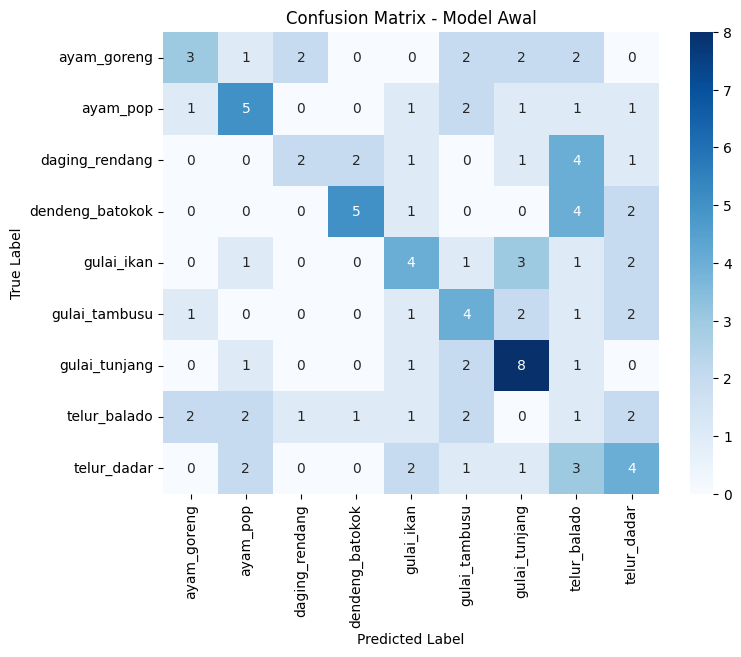

<ipython-input-7-c25e4a5d1792>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


Multi-class ROC curve disimpan di /content/drive/MyDrive/ProyekLogisticRegressionSaya/results/roc_curve_initial_multiclass.png


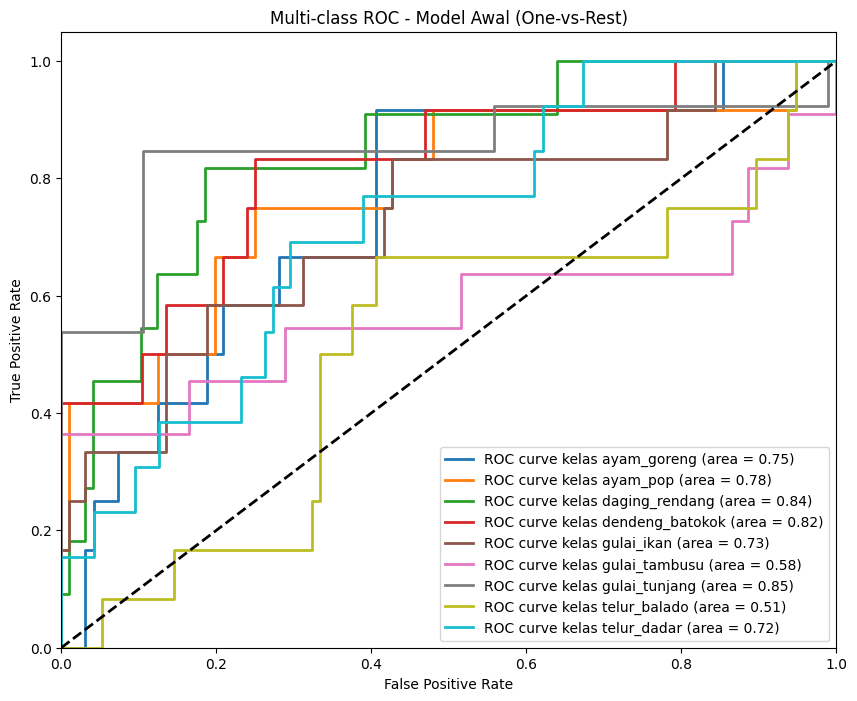

In [ ]:
# ==============================================================================
# SECTION 7: EVALUATION AND VISUALIZATION (INITIAL MODEL)
# ==============================================================================
print("\n--- Evaluasi Model Logistic Regression Awal ---")

if log_reg_initial and X_test_scaled.size > 0 and y_test_img.size > 0:
    try:
        y_pred_initial = log_reg_initial.predict(X_test_scaled)
        y_pred_proba_initial = log_reg_initial.predict_proba(X_test_scaled)

        accuracy_initial = accuracy_score(y_test_img, y_pred_initial)
        print(f"Akurasi Model Awal: {accuracy_initial:.4f}")

        print("\nLaporan Klasifikasi Model Awal:")
        # Pastikan le (LabelEncoder) ada dan telah di-fit
        if 'le' in locals() and le is not None:
             class_names_report = le.classes_
             print(classification_report(y_test_img, y_pred_initial, target_names=[str(cn) for cn in class_names_report])) # Convert class names to string
        else:
             print(classification_report(y_test_img, y_pred_initial))


        # Confusion Matrix
        cm_initial = confusion_matrix(y_test_img, y_pred_initial)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues',
                    xticklabels=le.classes_ if 'le' in locals() and le else 'auto',
                    yticklabels=le.classes_ if 'le' in locals() and le else 'auto')
        plt.title('Confusion Matrix - Model Awal')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        cm_initial_path = os.path.join(RESULTS_PATH, "confusion_matrix_initial.png")
        plt.savefig(cm_initial_path)
        print(f"Confusion matrix disimpan di {cm_initial_path}")
        plt.show()

        # ROC Curve (untuk klasifikasi biner atau One-vs-Rest untuk multi-class)
        # Untuk multi-class, kita bisa plot ROC untuk setiap kelas atau rata-rata
        if len(np.unique(y_train_img)) == 2: # Biner
            fpr, tpr, _ = roc_curve(y_test_img, y_pred_proba_initial[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic - Model Awal')
            plt.legend(loc="lower right")
            roc_initial_path = os.path.join(RESULTS_PATH, "roc_curve_initial.png")
            plt.savefig(roc_initial_path)
            print(f"ROC curve disimpan di {roc_initial_path}")
            plt.show()
        elif y_pred_proba_initial.shape[1] > 2 and 'le' in locals() and le: # Multi-class
            plt.figure(figsize=(10, 8))
            n_classes = y_pred_proba_initial.shape[1]
            colors = plt.cm.get_cmap('tab10', n_classes)

            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_test_img == i, y_pred_proba_initial[:, i]) # One-vs-Rest
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, color=colors(i), lw=2,
                         label=f'ROC curve kelas {le.classes_[i]} (area = {roc_auc:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Multi-class ROC - Model Awal (One-vs-Rest)')
            plt.legend(loc="lower right")
            roc_initial_multiclass_path = os.path.join(RESULTS_PATH, "roc_curve_initial_multiclass.png")
            plt.savefig(roc_initial_multiclass_path)
            print(f"Multi-class ROC curve disimpan di {roc_initial_multiclass_path}")
            plt.show()


    except Exception as e:
        print(f"Error saat evaluasi model awal: {e}")
else:
    print("Model awal tidak terlatih atau tidak ada data test untuk evaluasi.")

In [ ]:
# ==============================================================================
# SECTION 8: FINE-TUNING MODEL LOGISTIC REGRESSION
# ==============================================================================
print("\n--- Memulai Fine-Tuning Model Logistic Regression ---")

if X_train_scaled.size > 0 and y_train_img.size > 0 and X_val_scaled.size > 0 and y_val_img.size > 0:
    try:
        # Gabungkan train dan validation set untuk final tuning jika diinginkan,
        # atau gunakan val set untuk hyperparameter tuning. Di sini kita pakai val set terpisah.
        # Parameter grid untuk GridSearchCV
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100], # Regularization strength
            'penalty': ['l1', 'l2'],            # Regularization type
            'solver': ['liblinear']             # liblinear baik untuk l1 dan dataset kecil/medium
        }

        # Inisialisasi GridSearchCV
        # Menggunakan data validasi (X_val_scaled, y_val_img) untuk tuning
        # atau bisa juga menggunakan cross-validation pada X_train_scaled jika tidak ada X_val_scaled terpisah
        # Di sini kita asumsikan X_val_scaled dan y_val_img ada dan digunakan sbg 'test set' untuk GridSearchCV (kurang ideal, CV lebih baik)
        # Cara yang lebih baik: GridSearchCV dengan cv pada (X_train_scaled + X_val_scaled) atau hanya X_train_scaled

        # Kita akan gunakan cross-validation pada data training (X_train_scaled)
        grid_search = GridSearchCV(LogisticRegression(random_state=42, multi_class='auto', max_iter=2000),
                                   param_grid,
                                   cv=3, # 3-fold cross-validation, sesuaikan
                                   scoring='accuracy',
                                   verbose=1,
                                   n_jobs=-1) # Gunakan semua core CPU

        print("Melakukan GridSearchCV untuk fine-tuning...")
        grid_search.fit(X_train_scaled, y_train_img) # Fit pada data training

        best_params = grid_search.best_params_
        print(f"Parameter terbaik ditemukan: {best_params}")

        log_reg_tuned = grid_search.best_estimator_ # Model terbaik dari GridSearchCV
        print("Model Logistic Regression berhasil di-fine-tune.")

        # Simpan model hasil fine-tuning
        tuned_model_filename = os.path.join(MODEL_PATH, "logistic_regression_tuned.joblib")
        joblib.dump(log_reg_tuned, tuned_model_filename)
        print(f"Model hasil fine-tuning disimpan di: {tuned_model_filename}")

    except Exception as e:
        print(f"Error saat fine-tuning model: {e}")
        log_reg_tuned = None
else:
    print("Tidak ada data training/validasi yang cukup untuk fine-tuning.")
    log_reg_tuned = None


--- Memulai Fine-Tuning Model Logistic Regression ---
Melakukan GridSearchCV untuk fine-tuning...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Parameter terbaik ditemukan: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Model Logistic Regression berhasil di-fine-tune.
Model hasil fine-tuning disimpan di: /content/drive/MyDrive/ProyekLogisticRegressionSaya/models/logistic_regression_tuned.joblib



--- Evaluasi Model Logistic Regression Hasil Fine-Tuning ---
Akurasi Model Fine-Tuned: 0.4074

Laporan Klasifikasi Model Fine-Tuned:
                 precision    recall  f1-score   support

    ayam_goreng       0.25      0.17      0.20        12
       ayam_pop       0.40      0.50      0.44        12
 daging_rendang       0.55      0.55      0.55        11
dendeng_batokok       0.53      0.67      0.59        12
     gulai_ikan       0.29      0.33      0.31        12
  gulai_tambusu       0.27      0.27      0.27        11
  gulai_tunjang       0.56      0.69      0.62        13
   telur_balado       0.12      0.08      0.10        12
    telur_dadar       0.50      0.38      0.43        13

       accuracy                           0.41       108
      macro avg       0.39      0.41      0.39       108
   weighted avg       0.39      0.41      0.39       108

Confusion matrix fine-tuned disimpan di /content/drive/MyDrive/ProyekLogisticRegressionSaya/results/confusion_matrix_tuned

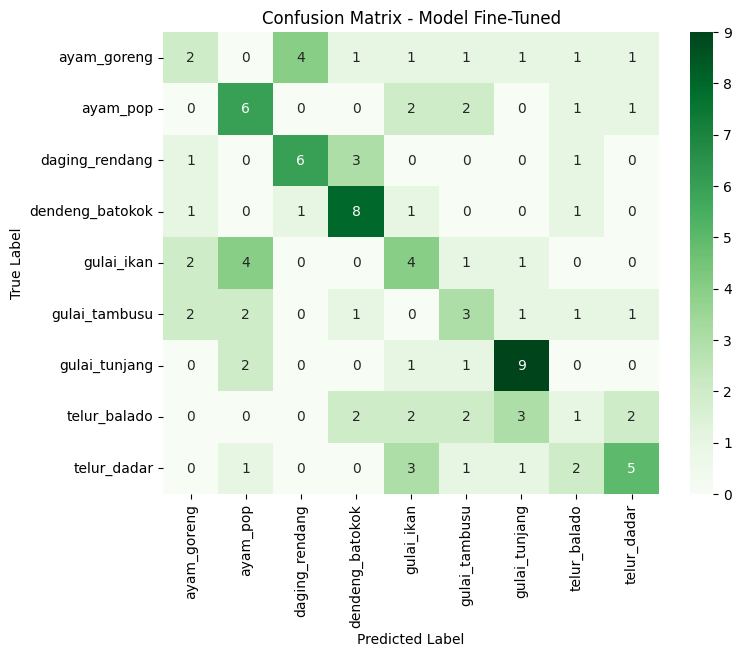

<ipython-input-40-301cb9a28fd8>:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


Multi-class ROC curve fine-tuned disimpan di /content/drive/MyDrive/ProyekLogisticRegressionSaya/results/roc_curve_tuned_multiclass.png


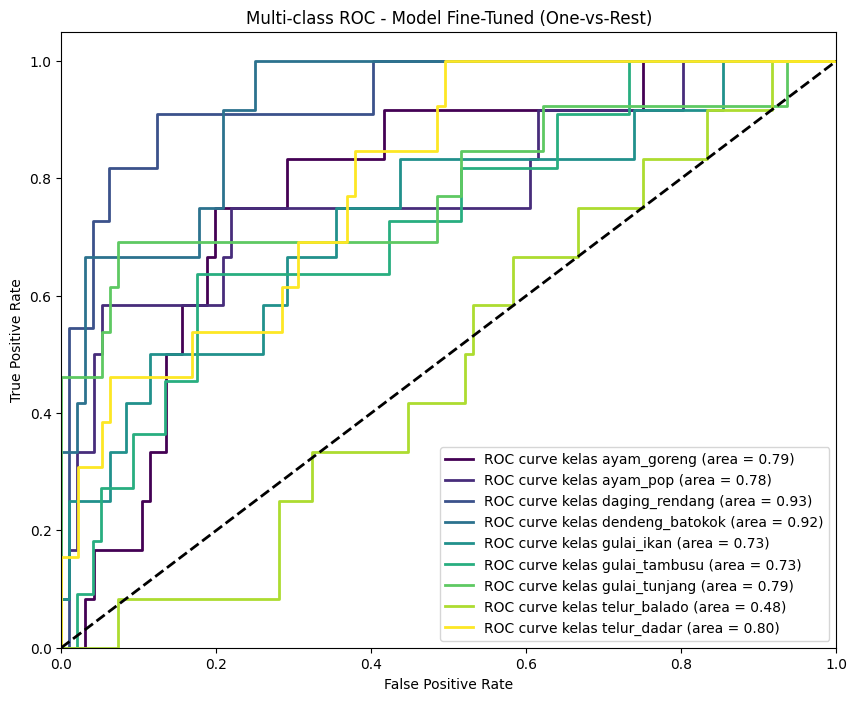

In [ ]:
# ==============================================================================
# SECTION 9: EVALUATION AND VISUALIZATION (FINE-TUNED MODEL)
# ==============================================================================
print("\n--- Evaluasi Model Logistic Regression Hasil Fine-Tuning ---")

if log_reg_tuned and X_test_scaled.size > 0 and y_test_img.size > 0:
    try:
        y_pred_tuned = log_reg_tuned.predict(X_test_scaled)
        y_pred_proba_tuned = log_reg_tuned.predict_proba(X_test_scaled)

        accuracy_tuned = accuracy_score(y_test_img, y_pred_tuned)
        print(f"Akurasi Model Fine-Tuned: {accuracy_tuned:.4f}")

        print("\nLaporan Klasifikasi Model Fine-Tuned:")
        if 'le' in locals() and le is not None:
             class_names_report = le.classes_
             print(classification_report(y_test_img, y_pred_tuned, target_names=[str(cn) for cn in class_names_report]))
        else:
             print(classification_report(y_test_img, y_pred_tuned))

        # Confusion Matrix
        cm_tuned = confusion_matrix(y_test_img, y_pred_tuned)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
                    xticklabels=le.classes_ if 'le' in locals() and le else 'auto',
                    yticklabels=le.classes_ if 'le' in locals() and le else 'auto')
        plt.title('Confusion Matrix - Model Fine-Tuned')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        cm_tuned_path = os.path.join(RESULTS_PATH, "confusion_matrix_tuned.png")
        plt.savefig(cm_tuned_path)
        print(f"Confusion matrix fine-tuned disimpan di {cm_tuned_path}")
        plt.show()

        # ROC Curve (untuk klasifikasi biner atau One-vs-Rest untuk multi-class)
        if len(np.unique(y_train_img)) == 2: # Biner
            fpr, tpr, _ = roc_curve(y_test_img, y_pred_proba_tuned[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic - Model Fine-Tuned')
            plt.legend(loc="lower right")
            roc_tuned_path = os.path.join(RESULTS_PATH, "roc_curve_tuned.png")
            plt.savefig(roc_tuned_path)
            print(f"ROC curve fine-tuned disimpan di {roc_tuned_path}")
            plt.show()
        elif y_pred_proba_tuned.shape[1] > 2 and 'le' in locals() and le: # Multi-class
            plt.figure(figsize=(10, 8))
            n_classes = y_pred_proba_tuned.shape[1]
            colors = plt.cm.get_cmap('viridis', n_classes)

            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_test_img == i, y_pred_proba_tuned[:, i]) # One-vs-Rest
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, color=colors(i), lw=2,
                         label=f'ROC curve kelas {le.classes_[i]} (area = {roc_auc:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Multi-class ROC - Model Fine-Tuned (One-vs-Rest)')
            plt.legend(loc="lower right")
            roc_tuned_multiclass_path = os.path.join(RESULTS_PATH, "roc_curve_tuned_multiclass.png")
            plt.savefig(roc_tuned_multiclass_path)
            print(f"Multi-class ROC curve fine-tuned disimpan di {roc_tuned_multiclass_path}")
            plt.show()

    except Exception as e:
        print(f"Error saat evaluasi model fine-tuned: {e}")
else:
    print("Model fine-tuned tidak terlatih atau tidak ada data test untuk evaluasi.")


--- Melakukan Inferensi dengan Model Terbaik (Fine-Tuned) ---
Menggunakan model hasil fine-tuning untuk inferensi.

Melakukan inferensi pada gambar contoh: /content/drive/MyDrive/ProyekLogisticRegressionSaya/datasets/processed/split_data/test/gulai_tambusu/gulai_tambusu (84).jpg


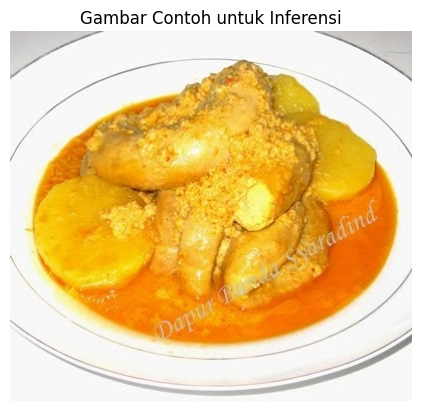

Prediksi Kelas: telur_dadar
Keyakinan (Confidence): 0.2276
Probabilitas untuk semua kelas:
  - ayam_goreng: 0.0121
  - ayam_pop: 0.2249
  - daging_rendang: 0.0013
  - dendeng_batokok: 0.0266
  - gulai_ikan: 0.1574
  - gulai_tambusu: 0.1801
  - gulai_tunjang: 0.1404
  - telur_balado: 0.0295
  - telur_dadar: 0.2276

--- Proses Selesai ---


In [ ]:
# ==============================================================================
# SECTION 10: INFERENCE
# ==============================================================================
print("\n--- Melakukan Inferensi dengan Model Terbaik (Fine-Tuned) ---")

# Pilih model terbaik (misalnya, model hasil fine-tuning jika ada dan lebih baik)
final_model = None
if 'log_reg_tuned' in locals() and log_reg_tuned is not None:
    final_model = log_reg_tuned
    print("Menggunakan model hasil fine-tuning untuk inferensi.")
elif 'log_reg_initial' in locals() and log_reg_initial is not None:
    final_model = log_reg_initial
    print("Menggunakan model awal untuk inferensi (model fine-tuned tidak tersedia).")
else:
    print("Tidak ada model yang tersedia untuk inferensi.")


if final_model and 'scaler' in locals() and 'le' in locals() and le is not None:
    def preprocess_single_image_for_inference(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
        try:
            img = Image.open(image_path).convert('L') # Grayscale
            img = img.resize(target_size)
            img_array = np.array(img)
            flattened_img = img_array.flatten().reshape(1, -1) # Reshape menjadi (1, n_features)
            scaled_img = scaler.transform(flattened_img.astype(np.float32)) # Gunakan scaler yang sudah di-fit
            return scaled_img
        except Exception as e:
            print(f"Error memproses gambar untuk inferensi {image_path}: {e}")
            return None

    def predict_image_class(image_path, model, label_encoder):
        processed_image = preprocess_single_image_for_inference(image_path)
        if processed_image is not None:
            prediction = model.predict(processed_image)
            predicted_proba = model.predict_proba(processed_image)
            predicted_class_index = prediction[0]
            predicted_class_name = label_encoder.inverse_transform([predicted_class_index])[0]
            confidence = predicted_proba[0][predicted_class_index]
            return predicted_class_name, confidence, predicted_proba[0]
        return None, None, None

    # Contoh inferensi pada satu gambar dari dataset test (jika ada)
    # Anda perlu menyediakan path ke gambar contoh
    # Misalnya, ambil gambar pertama dari folder test kelas pertama
    example_image_path = None
    if X_test_img.size > 0 and os.path.exists(os.path.join(SPLIT_OUTPUT_PATH, "test")):
        try:
            test_folder = os.path.join(SPLIT_OUTPUT_PATH, "test")
            first_class_folder = os.path.join(test_folder, os.listdir(test_folder)[0])
            if os.path.isdir(first_class_folder) and len(os.listdir(first_class_folder)) > 0:
                 example_image_name = os.listdir(first_class_folder)[0]
                 example_image_path = os.path.join(first_class_folder, example_image_name)
        except Exception as e:
            print(f"Tidak bisa mendapatkan contoh gambar dari test set: {e}")


    if example_image_path:
        print(f"\nMelakukan inferensi pada gambar contoh: {example_image_path}")
        try:
            img_display = Image.open(example_image_path)
            plt.imshow(img_display)
            plt.title("Gambar Contoh untuk Inferensi")
            plt.axis('off')
            plt.show()

            predicted_class, confidence, all_probas = predict_image_class(example_image_path, final_model, le)
            if predicted_class:
                print(f"Prediksi Kelas: {predicted_class}")
                print(f"Keyakinan (Confidence): {confidence:.4f}")
                print("Probabilitas untuk semua kelas:")
                for i, class_name_le in enumerate(le.classes_):
                    print(f"  - {class_name_le}: {all_probas[i]:.4f}")
            else:
                print("Gagal melakukan prediksi pada gambar contoh.")
        except Exception as e:
            print(f"Error saat inferensi gambar contoh: {e}")

    else:
        print("Tidak ada gambar contoh untuk inferensi, atau dataset test tidak termuat dengan benar.")
        print("Anda bisa mengganti 'example_image_path' dengan path ke gambar yang ingin Anda uji.")
        print("Contoh: my_image_path = '/content/drive/MyDrive/gambar_saya.jpg'")
        print("# predicted_class, confidence, _ = predict_image_class(my_image_path, final_model, le)")

else:
    if not final_model:
        print("Model tidak tersedia untuk inferensi.")
    if 'scaler' not in locals():
        print("Scaler tidak tersedia. Preprocessing tidak dapat dilakukan.")
    if 'le' not in locals() or le is None:
        print("LabelEncoder tidak tersedia. Nama kelas tidak dapat dipetakan.")

print("\n--- Proses Selesai ---")